# Initial Data Analysis

The goal of this notebook is to visualize the transformed data that we have from the spark cluster. See what we have, and what to do next.

In [127]:
import pandas as pd
import numpy as np
import glob

input = 'submissions-transformed/part-*.json.gz'

In [128]:
# read in the transformed data
etl_filename = glob.glob(input)[0]
submissions = pd.read_json(etl_filename, lines=True)

In [129]:
submissions.dtypes

created_on        int64
age               int64
year              int64
month             int64
day               int64
hour              int64
day_of_week       int64
subreddit        object
author           object
post_count        int64
over_18           int64
gilded            int64
archived        float64
quarantine        int64
stickied          int64
num_comments      int64
score             int64
title_length      int64
title            object
selftext         object
dtype: object

## 1. Overall Summary Statistics

In [130]:
# 257121 number of submissions in dataset
submissions.shape

(257121, 20)

In [131]:
# View summary stats
submissions[['score', 'num_comments']].describe()

,score,num_comments
count,257121.000000,257121.000000
mean,53.211041,16.502565
std,1255.202270,310.699312
min,0.000000,0.000000
25%,1.000000,1.000000
50%,2.000000,4.000000
75%,4.000000,10.000000
max,111063.000000,59146.000000


# 2. Visualizations of Data

In [132]:
import matplotlib.pyplot as plt

### 2.1 Distribution of Score and Comments

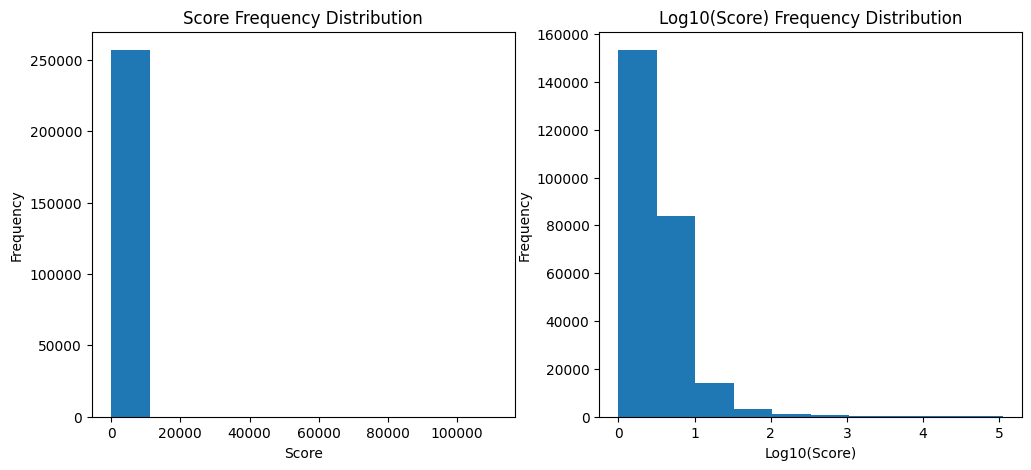

In [133]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

axes[0].hist(submissions['score'])
axes[0].set_title('Score Frequency Distribution')
axes[0].set_xlabel('Score')
axes[0].set_ylabel('Frequency')

scores = submissions['score'].values
# scores = scores[scores > 2]
scores = np.log10(scores + 1)
axes[1].hist(scores)
axes[1].set_title('Log10(Score) Frequency Distribution')
axes[1].set_xlabel('Log10(Score)')
axes[1].set_ylabel('Frequency')

fig.show()

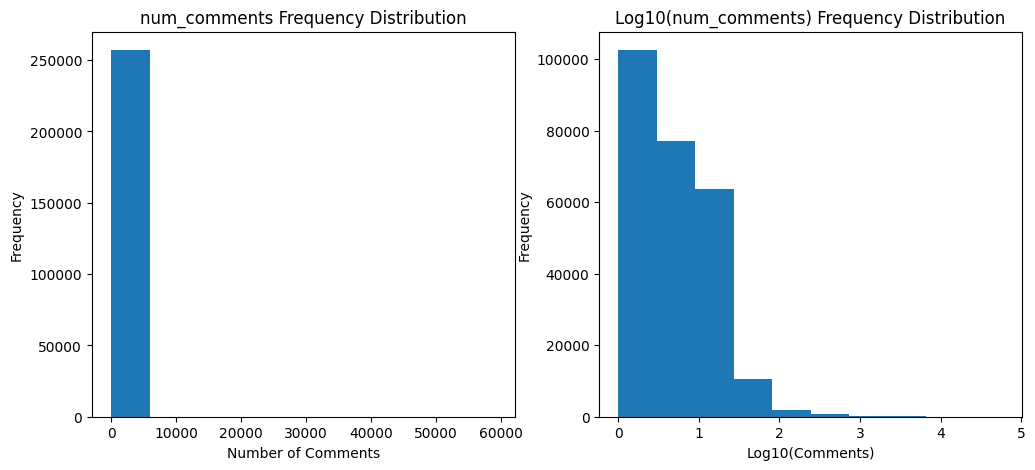

In [134]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

axes[0].hist(submissions['num_comments'])
axes[0].set_title('num_comments Frequency Distribution')
axes[0].set_xlabel('Number of Comments')
axes[0].set_ylabel('Frequency')

comments = submissions['num_comments'].values
# comments = comments[comments > 2]
comments = np.log10(comments + 1)
axes[1].hist(comments)
axes[1].set_title('Log10(num_comments) Frequency Distribution')
axes[1].set_xlabel('Log10(Comments)')
axes[1].set_ylabel('Frequency')

fig.show()

### 2.2 Scatter Plots: time vs score and time vs comments

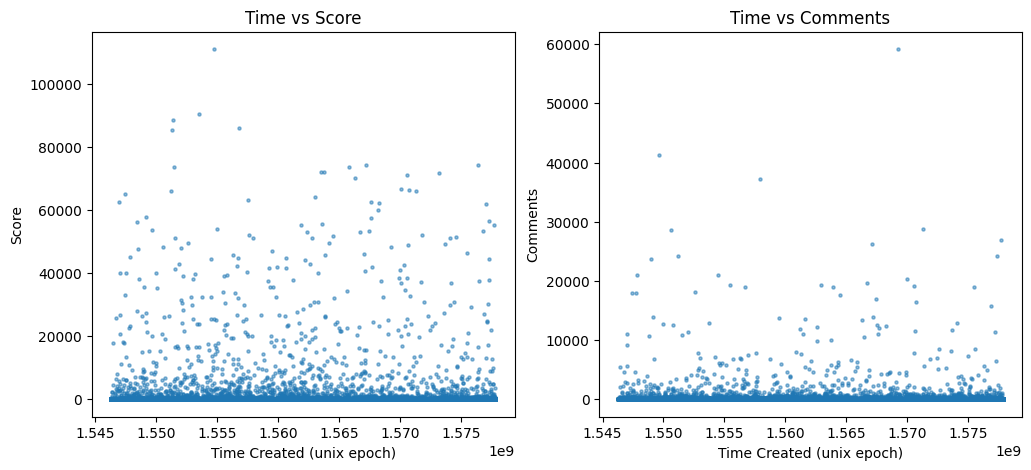

In [135]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

axes[0].scatter(submissions['created_on'], submissions['score'], alpha=0.5, s=5 )
axes[0].set_title('Time vs Score')
axes[0].set_xlabel('Time Created (unix epoch)')
axes[0].set_ylabel('Score')

axes[1].scatter(submissions['created_on'], submissions['num_comments'], alpha=0.5, s=5 )
axes[1].set_title('Time vs Comments')
axes[1].set_xlabel('Time Created (unix epoch)')
axes[1].set_ylabel('Comments')

fig.show()

## 3. Analysis of Data Skewness


- Measures such as score and num_comments is heavily right skewed (based on the dataframe describe and histogram visualizations)
- A large majority of reddit submissions are seen as "not good".
- 99% of our data are submissions with score less than 129
- Only 1% of data have scores over 129

In [174]:
submissions['score'].quantile(0.99)

129.0

In [176]:
ninety_nine = submissions[submissions['score'] <= 129] 
one_percent = submissions[submissions['score'] > 129]

In [181]:
ninety_nine[['score', 'num_comments']].describe()

,score,num_comments
count,254551.000000,254551.000000
mean,3.868301,8.071585
std,8.335211,16.549134
min,0.000000,0.000000
25%,1.000000,1.000000
50%,2.000000,4.000000
75%,4.000000,10.000000
max,129.000000,914.000000


In [180]:
one_percent[['score', 'num_comments']].describe()

,score,num_comments
count,2570.000000,2570.000000
mean,4940.465370,851.566537
std,11556.189511,2988.292119
min,130.000000,0.000000
25%,228.000000,21.000000
50%,561.000000,76.000000
75%,3117.500000,457.750000
max,111063.000000,59146.000000


### 3.1 Looking at Submissions in the Top 1% of Score

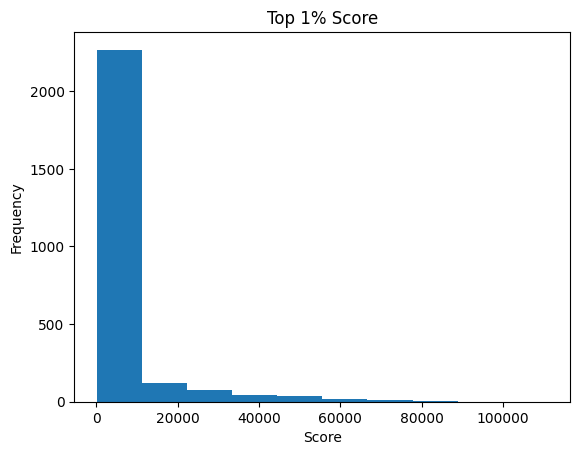

In [207]:
plt.hist(one_percent['score'])
plt.title('Top 1% Score')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

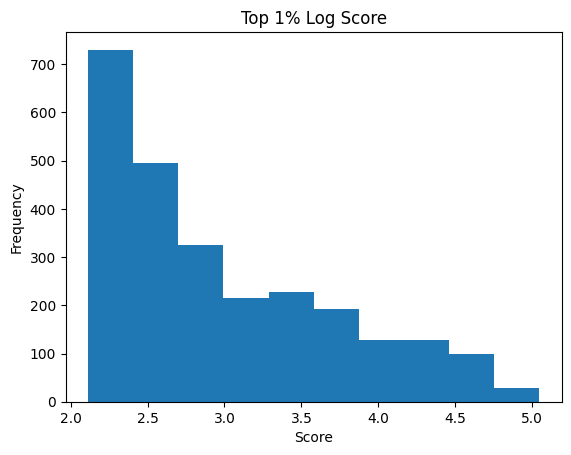

In [208]:
transformed_one_percent = one_percent['score'].values
transformed_one_percent = np.log10(transformed_one_percent)
plt.hist(transformed_one_percent)
plt.title('Top 1% Log Score')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

### 3.2 Looking at Submissions in the Top 0.1% of Score

In [197]:
submissions['score'].quantile(0.999)

14402.680000005435

In [200]:
zero_one_percent = one_percent[one_percent['score'] > 14402]
zero_one_percent[['score', 'num_comments']].describe()

,score,num_comments
count,258.000000,258.000000
mean,34366.410853,4723.709302
std,17469.386795,7937.253667
min,14422.000000,133.000000
25%,20700.250000,414.500000
50%,28466.000000,786.000000
75%,44514.500000,6028.250000
max,111063.000000,59146.000000


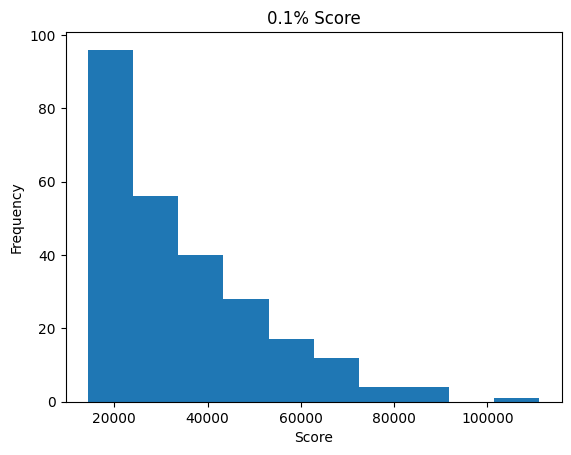

In [199]:
plt.hist(zero_one_percent['score'])
plt.title('Top 0.1% Score')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

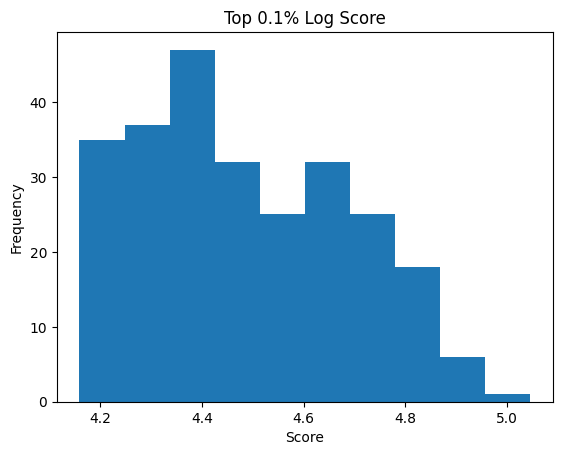

In [210]:
transformed_one_percent = zero_one_percent['score'].values
transformed_one_percent = np.log10(transformed_one_percent)
plt.hist(transformed_one_percent)
plt.title('Top 0.1% Log Score')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

# 4. Next Steps

Where do we go from here? We have only around 2k data points where the performance can be seen as "good" (score/upvotes > 129).  
Lets keep all the submission data within the top 1%, and subsample an equivalent number of submissions from the 99% to balance the dataset out a bit more.  
